# **Libraries**

In [3]:
# Core
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
import os
import random
from glob import glob
import math
from tqdm import tqdm
from pathlib import Path


# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, models, transforms
from torch.nn import functional as F

**Mounts Google Drive to the '/content/drive' directory with forced remounting option for seamless file access and storage**

In [4]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# **Ensuring reproducibility with consistent random seed initialization**

In [5]:
def set_random_seeds(seed=0):
    """
    Set random seeds for NumPy, Python random, and PyTorch for reproducibility.

    Parameters:
    seed (int): Seed value for random number generation. Default is 0.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

set_random_seeds()

# **Choosing device for computation based on GPU availability to optimize performance**

In [6]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# **Hyperparameters have been set for a neural network model, which include batch size, learning rate, epochs, layer sizes, activation function, and model type, as well as paths for training and testing data**

In [7]:
hyperparameters = {
    'batch_size': 16,
    'lr': 0.001,
    'epochs': 50,
    'layer1_size': 128,
    'layer2_size': 128,
    'activation': 'relu',
    'model_type': 'resnet50',
    'factor': 5
}

train_data_path = r'/content/drive/MyDrive/synthetic_image_detection/data/large_data/training_data'
test_data_path = r'/content/drive/MyDrive/synthetic_image_detection/data/large_data/testing_data'

# **Investigate the distribution of classes within the dataset**

**The datasets include synthetic and real images, with some classes only present in the test set to evaluate model generalization.
The data follows an 80-20 split, with 80% of each class used for training and 20% for testing to ensure robustness across unseen categories**

<ipython-input-8-1b78cf6cf6f2>:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=all_classes, y=num_imgs, palette=colors_subset, ax=ax)
<ipython-input-8-1b78cf6cf6f2>:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=all_classes, y=num_imgs, palette=colors_subset, ax=ax)


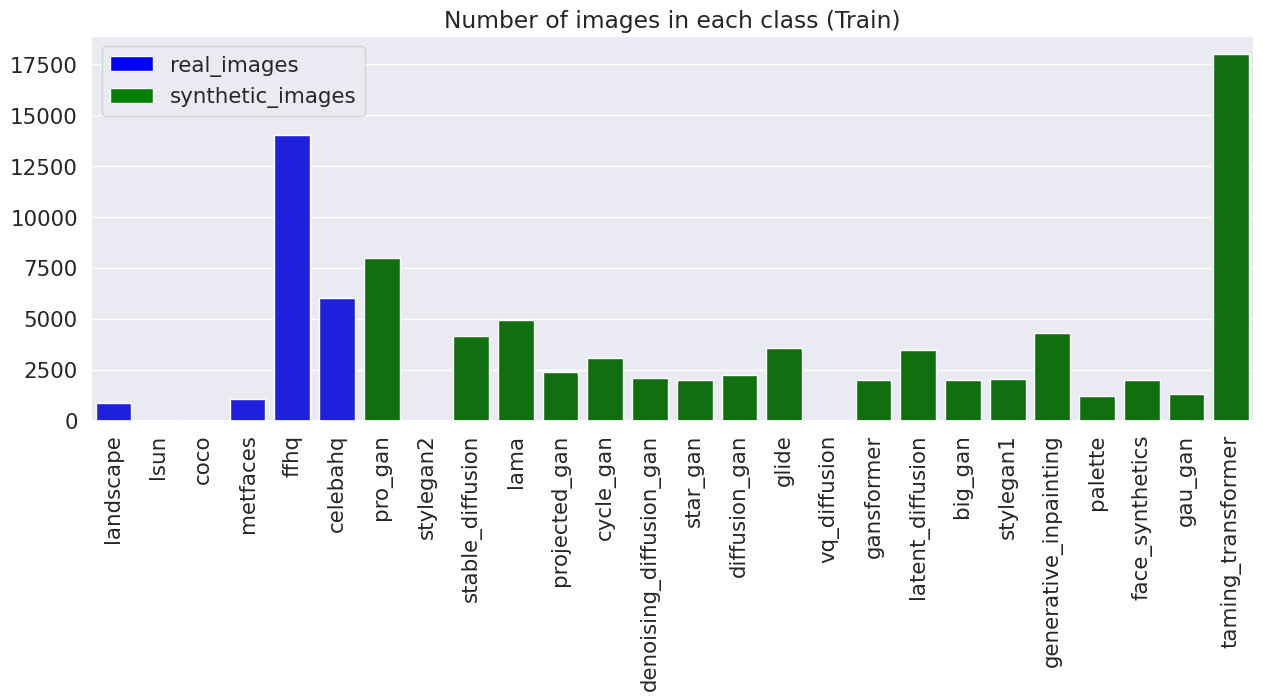

<ipython-input-8-1b78cf6cf6f2>:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=all_classes, y=num_imgs, palette=colors_subset, ax=ax)
<ipython-input-8-1b78cf6cf6f2>:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=all_classes, y=num_imgs, palette=colors_subset, ax=ax)


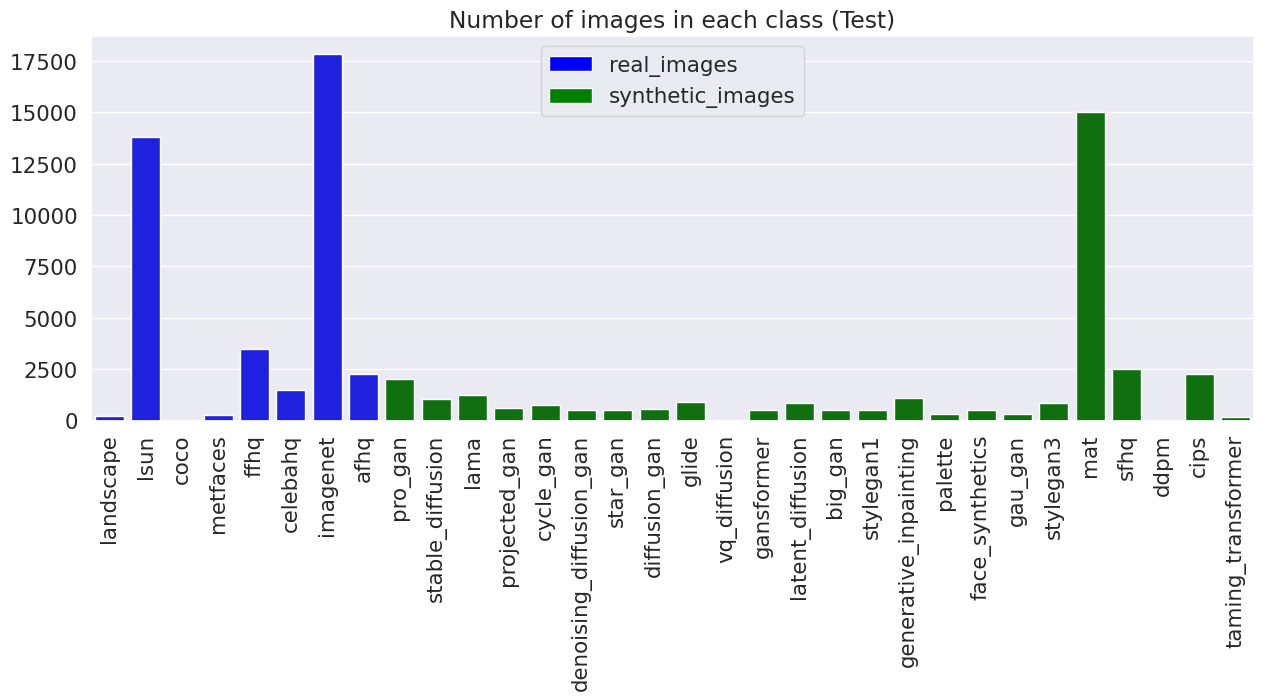

In [8]:
def plot_images_per_class(data_path, title):
    """
    Plot the number of images in each class based on the provided data path.

    Parameters:
    - data_path (str): Path to the data containing class folders.
    - title (str): Title for the plot.

    Returns:
    - all_classes (list): List of all class names found in the data path.
    """

    all_classes = []
    num_imgs = []
    colors = {}
    colors_list = ['blue', 'green']

    data_classes = sorted(glob(data_path + '/*'))

    fig, ax = plt.subplots(figsize=(15, 5))

    for idx, folder in enumerate(data_classes):
        train_folders = [os.path.join(folder, subfolder) for subfolder in os.listdir(folder) if os.path.isdir(os.path.join(folder, subfolder))]
        parent_folder_name = folder.split('/')[-1]

        color = colors_list[idx % len(colors_list)]

        for path in train_folders:
            class_name = path.split('/')[-1]
            all_classes.append(class_name)

            num = len(glob(path + '/*'))
            num_imgs.append(num)

            colors[class_name] = color

        colors_subset = [colors[class_name] for class_name in all_classes]
        sns.barplot(x=all_classes, y=num_imgs, palette=colors_subset, ax=ax)

    plt.title(title)
    plt.xticks(rotation=90)

    legend_labels = [plt.Rectangle((0, 0), 1, 1, fc=color) for color in colors_list]
    plt.legend(legend_labels, [os.path.split(folder)[-1] for folder in data_classes])

    plt.show()
    return all_classes

all_classes_training = plot_images_per_class(train_data_path, 'Number of images in each class (Train)')
all_classes_test = plot_images_per_class(test_data_path, 'Number of images in each class (Test)')

classes = list(set(all_classes_training + all_classes_test))


# **Transforming the data through normalization and augmenting techniques**

In [9]:
# Set mean and std values for normalization
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

# Define transformations for training data
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=5),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=norm_mean, std=norm_std)
])

# Define transformations for testing data
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=norm_mean, std=norm_std)
])

# **Showing image renderings from all synthetic image generative algorithms and from all real image datasets.**

In [10]:
IMG_EXTENSIONS = ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')

train_dataset = datasets.DatasetFolder(train_data_path, loader=lambda x: Image.open(x), extensions=IMG_EXTENSIONS, transform=train_transforms)
test_dataset = datasets.DatasetFolder(test_data_path, loader=lambda x: Image.open(x), extensions=IMG_EXTENSIONS, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=hyperparameters['batch_size'], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=hyperparameters['batch_size'], shuffle=False)

In [11]:
train_dataset.classes

['real_images', 'synthetic_images']

In [12]:
train_dataset.classes

['real_images', 'synthetic_images']

In [13]:
import random

# Get a random sample of 10 images
random_indices = random.sample(range(len(train_dataset)), 10)

# Print the path of each image along with its label
for idx in random_indices:
    image_path, label = train_dataset.samples[idx]
    print(f"Image Path: {image_path} - Label: {label}")

Image Path: /content/drive/MyDrive/synthetic_image_detection/data/large_data/training_data/synthetic_images/taming_transformer/img039213.jpg - Label: 1
Image Path: /content/drive/MyDrive/synthetic_image_detection/data/large_data/training_data/synthetic_images/lama/img006479.jpg - Label: 1
Image Path: /content/drive/MyDrive/synthetic_image_detection/data/large_data/training_data/synthetic_images/stylegan2/img093534.jpg - Label: 1
Image Path: /content/drive/MyDrive/synthetic_image_detection/data/large_data/training_data/synthetic_images/pro_gan/img004761.jpg - Label: 1
Image Path: /content/drive/MyDrive/synthetic_image_detection/data/large_data/training_data/real_images/ffhq/img022853.jpg - Label: 0
Image Path: /content/drive/MyDrive/synthetic_image_detection/data/large_data/training_data/real_images/lsun/img093987.jpg - Label: 0
Image Path: /content/drive/MyDrive/synthetic_image_detection/data/large_data/training_data/synthetic_images/stylegan2/img008013.jpg - Label: 1
Image Path: /cont

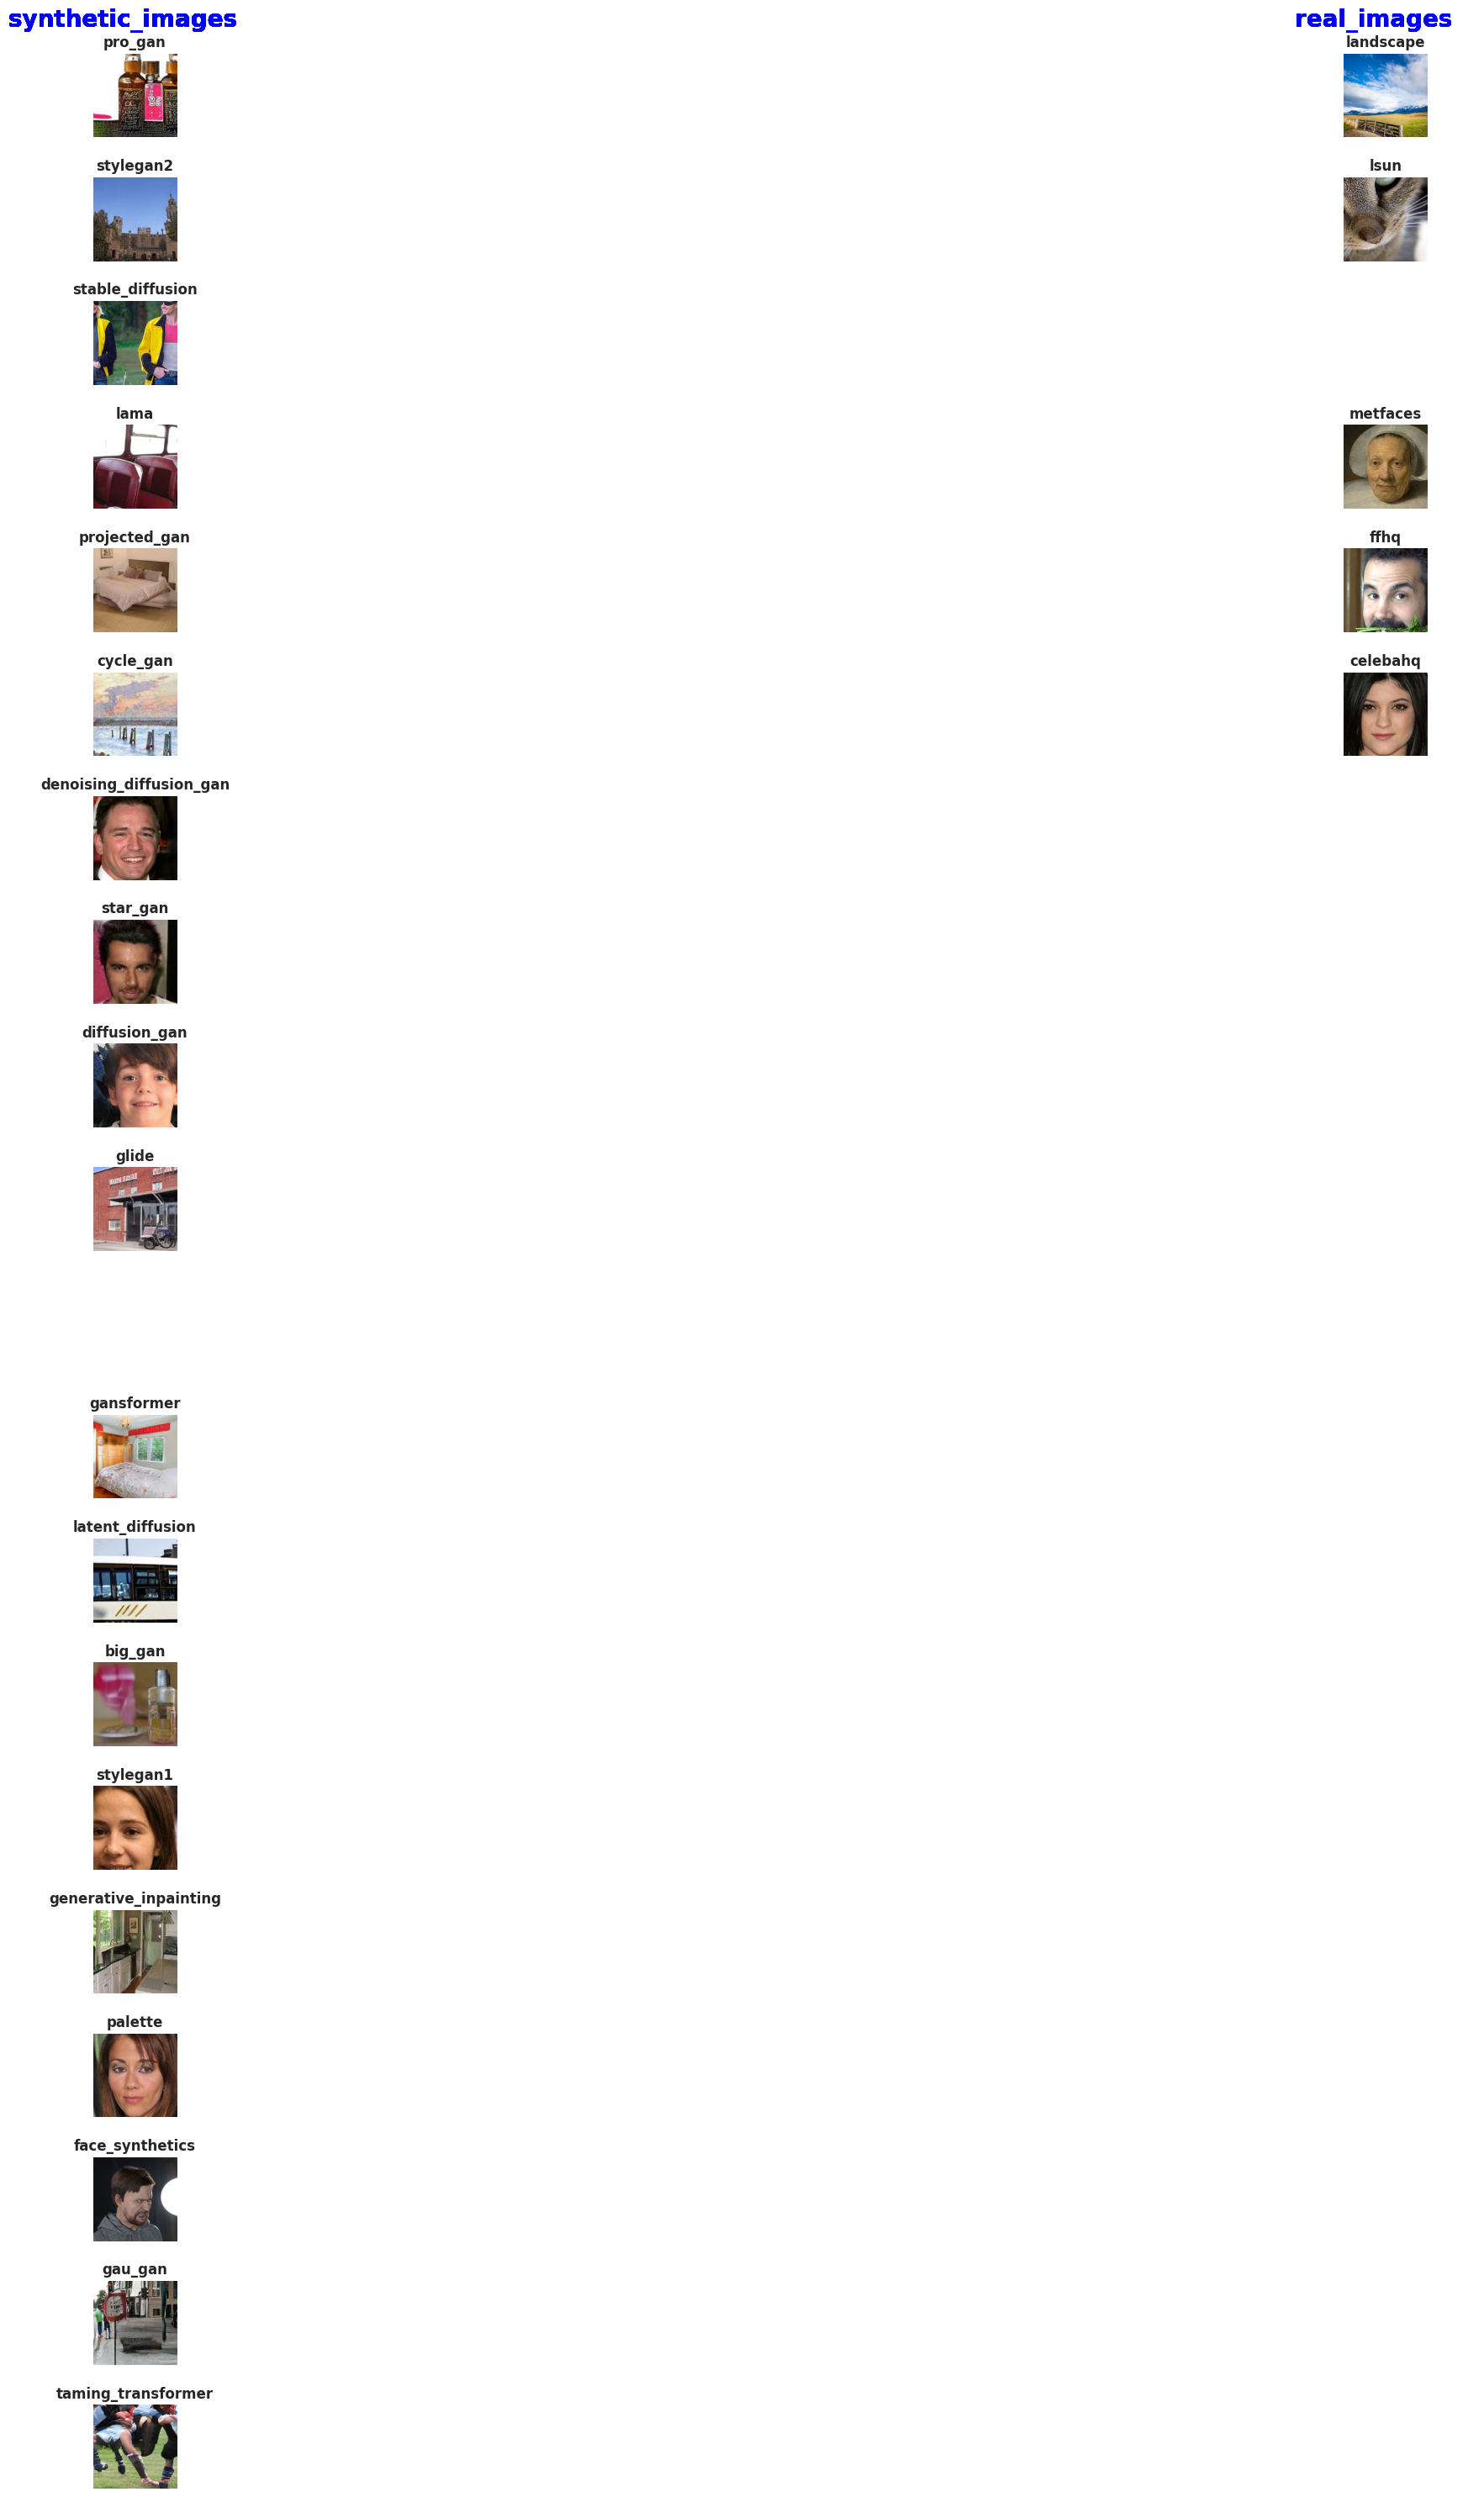

In [14]:
import os
from PIL import Image
import matplotlib.pyplot as plt

train_sources = [f.path for f in os.scandir(train_data_path) if f.is_dir()]

first_source = os.path.basename(train_sources[0])
second_source = os.path.basename(train_sources[1])

plt.figure(figsize=(30, 30))

# Display images from subfolders of the first and second sources
first_source_path = os.path.join(train_data_path, first_source)
subfolders_first = [f.path for f in os.scandir(first_source_path) if f.is_dir()]

second_source_path = os.path.join(train_data_path, second_source)
subfolders_second = [f.path for f in os.scandir(second_source_path) if f.is_dir()]

max_subfolders = max(len(subfolders_first), len(subfolders_second))

for j in range(max_subfolders):
    if j < len(subfolders_first):
        subfolder = subfolders_first[j]
        subfolder_tag = subfolder.split(os.sep)[-1]
        source = first_source
        subfolder_images = os.listdir(subfolder)

        if subfolder_images:
            image_path = os.path.join(subfolder, subfolder_images[0])
            image = Image.open(image_path)

            plt.subplot(max_subfolders, 2, j*2 + 1)
            plt.imshow(image)
            plt.title(subfolder_tag, fontweight='bold', fontsize=12)
            plt.axis('off')

            plt.subplot(max_subfolders, 2, 1)
            plt.text(0.5, 1.4, f"{source}   ", color='blue', fontsize=20, fontweight='bold', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

    if j < len(subfolders_second):
        subfolder = subfolders_second[j]
        subfolder_tag = subfolder.split(os.sep)[-1]
        source = second_source
        subfolder_images = os.listdir(subfolder)

        if subfolder_images:
            image_path = os.path.join(subfolder, subfolder_images[0])
            image = Image.open(image_path)

            plt.subplot(max_subfolders, 2, j*2 + 2)
            plt.imshow(image)
            plt.title(subfolder_tag, fontweight='bold', fontsize=12)
            plt.axis('off')

            plt.subplot(max_subfolders, 2, 2)
            plt.text(0.5, 1.4, f"{source}   ", color='blue', fontsize=20, fontweight='bold', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

# **Approach:**
# Implementing transfer learning with PyTorch.

In [15]:
# Load the ResNet50 model pre-trained on ImageNet
model = models.resnet50(pretrained=True).to(device)

# Freeze the layers of the ResNet50 model
for param in model.parameters():
    param.requires_grad = False

# Add a new classification head to the model with Dropout
model.fc = nn.Sequential(
    nn.Linear(2048, hyperparameters['layer1_size']),
    nn.ReLU(),
    nn.Dropout(0.7),  # Add dropout with 50% probability
    nn.Linear(hyperparameters['layer2_size'], len(classes))
).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 125MB/s]


In [16]:
# Define the CrossEntropyLoss criterion
criterion = nn.CrossEntropyLoss()

# Define the optimizer with weight decay for regularization using AdamW
optimizer = optim.AdamW(model.fc.parameters(), weight_decay=1e-5)  # Adding weight decay for regularization

# Learning rate scheduler
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=hyperparameters['epochs'])

# **Auxiliary functions**

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [23]:
def train_one_epoch(train_loader, model, criterion, optimizer, scheduler):
    """
    Perform one epoch of training on the provided data.

    Parameters:
    - train_loader (DataLoader): DataLoader for training data.
    - model (torch.nn.Module): The neural network model.
    - criterion (torch.nn.Module): The loss function.
    - optimizer (torch.optim.Optimizer): The optimizer for updating model parameters.
    - scheduler (torch.optim.lr_scheduler): Learning rate scheduler.

    Returns:
    - Tuple of average loss and accuracy for the epoch.
    """

    model.train()  # Set model in training mode
    loss_epoch = 0
    accuracy_epoch = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss_epoch += loss.detach().item()

        _, preds = torch.max(outputs, 1)
        accuracy_epoch += torch.sum(preds == labels) / inputs.shape[0]

    scheduler.step()

    return loss_epoch / len(train_loader), accuracy_epoch.item() / len(train_loader)

def evaluate_one_epoch(test_loader, model, criterion):
    """
    Evaluate the model on the provided test data for one epoch.

    Parameters:
    - test_loader (DataLoader): DataLoader for test data.
    - model (torch.nn.Module): The neural network model.
    - criterion (torch.nn.Module): The loss function.

    Returns:
    - Tuple of average loss and accuracy for the epoch.
    """

    model.eval()  # Set model in evaluation mode
    loss_epoch = 0
    accuracy_epoch = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss_epoch += loss.detach().item()

            _, preds = torch.max(outputs, 1)
            accuracy_epoch += torch.sum(preds == labels) / inputs.shape[0]

    return loss_epoch / len(test_loader), accuracy_epoch.item() / len(test_loader)

def plot_hist(train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist):
    """
    Plot the training and testing loss and accuracy history.

    Parameters:
    - train_loss_hist (list): List of training loss values.
    - test_loss_hist (list): List of testing loss values.
    - train_acc_hist (list): List of training accuracy values.
    - test_acc_hist (list): List of testing accuracy values.
    """

    plt.figure(figsize=(15, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_loss_hist, label='Train_Loss')
    plt.plot(test_loss_hist, label='Test_loss')
    plt.title('Cross Entropy Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_acc_hist, label='Train_Accuracy')
    plt.plot(test_acc_hist, label='Val_Accuracy')
    plt.title('Accuracy')
    plt.legend()

    plt.show()


def save_stats(file_path, model):
    """
    Save the state dictionary of a PyTorch model to a file.

    Args:
        file_path (str or Path): File path where the model state will be saved.
        model (torch.nn.Module): PyTorch model whose state will be saved.
    """
    torch.save(model.state_dict(), file_path)

# **Model Training**

In [24]:

def train_model(model, criterion, optimizer, scheduler, train_loader, test_loader, checkpoint_dir, verbose=True):
    # Initialise outputs
    train_loss_hist = []
    test_loss_hist = []
    train_acc_hist = []
    test_acc_hist = []
    check_dir = Path(checkpoint_dir)

    # Loop over epochs
    for epoch in range(hyperparameters['epochs']):
        print(f'Epoch: {epoch + 1}')
        # Train
        train_loss, train_accuracy = train_one_epoch(train_loader, model, criterion, optimizer, scheduler)

        # Evaluate
        test_loss, test_accuracy = evaluate_one_epoch(test_loader, model, criterion)

        # Track metrics
        train_loss_hist.append(train_loss)
        test_loss_hist.append(test_loss)
        train_acc_hist.append(train_accuracy)
        test_acc_hist.append(test_accuracy)

        epochs_list = list(range(1, hyperparameters["epochs"] + 1))
        pbar = tqdm(total=len(epochs_list), desc='')

        pbar.update()

        if (epoch % hyperparameters['factor']) == 0:
            if epoch > 0:
                save_stats(check_dir / ('chk_' + str(epoch) + '.pt'), model)
        pbar.postfix = f'Epoch {epoch+1}/{hyperparameters["epochs"]}, loss {train_loss:.5f}, test_loss {test_loss:.5f}, accuracy {train_accuracy:.5f}, test_accuracy {test_accuracy:.5f}'


    return train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist


In [ ]:
# Train
checkpoint_dir = r'/content/drive/My Drive/synthetic_image_detection/data_driven/checkpoints'
train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist = train_model(model, criterion, optimizer, scheduler, train_loader, test_loader, checkpoint_dir, verbose=True)
# Save model
torch.save(model.state_dict(), 'resnet.h5')

Epoch: 1


Evaluation
Learning curves

In [ ]:

plot_hist(train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist)

# Test accuracy breakdown

# Evaluation mode (turn off dropout)
model.eval()

with torch.no_grad():
    n_correct=0
    n_samples=0

    n_class_correct = [0 for i in range(len(classes))]
    n_class_sample = [0 for i in range(len(classes))]

    for inputs, labels in test_loader:
        # Send to device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Predictions
        _, preds = torch.max(outputs, 1)

        n_samples += labels.shape[0]
        n_correct += (preds == labels.data).sum().item()

        for i in range(hyperparameters['batch_size']):
            try:
                label = labels[i].item()
                pred = preds[i].item()
            except:
                break

            if (label==pred):
                n_class_correct[label]+=1
            n_class_sample[label]+=1

    acc = 100 * n_correct/n_samples
    print(f'Overall accuracy on test set: {acc:.1f} %')

    for i in range(len(classes)):
        print(f'Accuracy of {classes[i]}: {100* n_class_correct[i]/n_class_sample[i]:.1f} %')

